In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
ds =  xr.open_mfdataset('C:/Users/ampon/Desktop/PYTHON/TEMP_1994_2024/*.nc')
ds

<xarray.Dataset>
Dimensions:     (valid_time: 271752, latitude: 31, longitude: 21)
Coordinates:
    number      int64 0
  * valid_time  (valid_time) datetime64[ns] 1994-01-01 ... 2024-12-31T23:00:00
  * latitude    (latitude) float64 12.0 11.75 11.5 11.25 ... 5.25 5.0 4.75 4.5
  * longitude   (longitude) float64 -3.5 -3.25 -3.0 -2.75 ... 0.75 1.0 1.25 1.5
    expver      (valid_time) object dask.array<chunksize=(17520,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(17520, 31, 21), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-26T13:26 GRIB to CDM+CF via cfgrib-0.9.1...

PARAMETER EXTRACTION

In [3]:
# Daily maximum, minimum, mean
Tmax = ds["t2m"].resample(valid_time="1D").max()
Tmin = ds["t2m"].resample(valid_time="1D").min()
Tmean = ds["t2m"].resample(valid_time="1D").mean()

# Put them into one Dataset
ds_daily = xr.Dataset({
    "Tmax": Tmax,
    "Tmin": Tmin,
    "Tmean": Tmean
})


In [4]:
ds_daily.to_netcdf('ds_daily.nc')

In [5]:
ds_daily

<xarray.Dataset>
Dimensions:     (latitude: 31, longitude: 21, valid_time: 11323)
Coordinates:
    number      int64 0
  * latitude    (latitude) float64 12.0 11.75 11.5 11.25 ... 5.25 5.0 4.75 4.5
  * longitude   (longitude) float64 -3.5 -3.25 -3.0 -2.75 ... 0.75 1.0 1.25 1.5
  * valid_time  (valid_time) datetime64[ns] 1994-01-01 1994-01-02 ... 2024-12-31
Data variables:
    Tmax        (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
    Tmin        (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
    Tmean       (valid_time, latitude, longitude) float32 dask.array<chunksize=(1, 31, 21), meta=np.ndarray>

PERCENTILE CALCULATION

In [6]:
# Rechunk so that 'valid_time' is a single chunk
ds_daily = ds_daily.chunk({"valid_time": -1})

# Now compute thresholds over the full 1994–2024 period
tmax_p975 = ds_daily["Tmax"].quantile(0.975, dim="valid_time")
tmax_p81  = ds_daily["Tmax"].quantile(0.81,  dim="valid_time")


In [8]:
tmax_p975

<xarray.DataArray 'Tmax' (latitude: 31, longitude: 21)>
dask.array<getitem, shape=(31, 21), dtype=float64, chunksize=(31, 21), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 12.0 11.75 11.5 11.25 ... 5.25 5.0 4.75 4.5
  * longitude  (longitude) float64 -3.5 -3.25 -3.0 -2.75 ... 0.75 1.0 1.25 1.5
    quantile   float64 0.975

THRESHOLD EXCEEDANCE

In [7]:
exceed_p975 = ds_daily["Tmax"] > tmax_p975
exceed_p81  = ds_daily["Tmax"] > tmax_p81


HEATWAVES DETECTION

In [14]:
import numpy as np
import xarray as xr

def detect_heatwaves(exceedances, min_duration=3):
    """
    Identify heatwave days (True/False) where exceedances persist 
    for at least `min_duration` consecutive days.
    """
    # Convert to numpy for easier processing
    exceed = exceedances.values.astype(int)

    hw_mask = np.zeros_like(exceed, dtype=bool)

    for i in range(exceed.shape[1]):      # loop over lat
        for j in range(exceed.shape[2]):  # loop over lon
            series = exceed[:, i, j]
            
            run_length = 0
            for t in range(len(series)):
                if series[t] == 1:
                    run_length += 1
                else:
                    if run_length >= min_duration:
                        hw_mask[t-run_length:t, i, j] = True
                    run_length = 0
            # Handle run at the end
            if run_length >= min_duration:
                hw_mask[len(series)-run_length:, i, j] = True

    return xr.DataArray(
        hw_mask,
        coords=exceedances.coords,
        dims=exceedances.dims,
        name="heatwave"
    )


In [15]:
heatwave_mask = detect_heatwaves(exceed_p975, min_duration=3)


In [16]:
# Add year as coordinate
years = ds_daily["valid_time"].dt.year

# Heatwave frequency (number of separate events per year)
def count_events(mask, year):
    # Shift to detect event starts
    start = mask & ~mask.shift(valid_time=1, fill_value=False)
    return start.groupby(year).sum(dim="valid_time")

hw_frequency = count_events(heatwave_mask, years)

# Heatwave duration (total number of HW days per year)
hw_duration = heatwave_mask.groupby(years).sum(dim="valid_time")

# Heatwave intensity (mean exceedance above threshold)
hw_intensity = (
    (ds_daily["Tmax"] - tmax_p975)
    .where(heatwave_mask)
    .groupby(years)
    .mean(dim="valid_time")
)


In [23]:
import geopandas as gpd

# Load shapefile
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp")

# Check CRS
print(ghana.crs)


EPSG:4326


In [24]:
ghana = ghana.to_crs("EPSG:4326")


In [26]:
import regionmask
import xarray as xr

# Build a mask from shapefile polygons
mask = regionmask.Regions([ghana.geometry.iloc[0]])

# Apply mask to your heatwave frequency
hw_freq_masked = hw_freq_mean.where(mask.mask(hw_freq_mean) == 0)


C:\Users\ampon\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


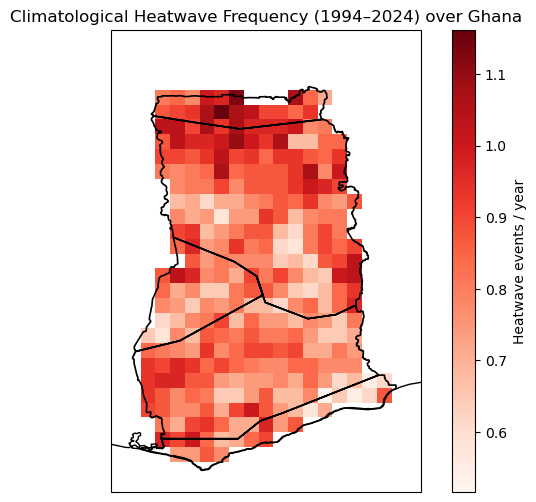

In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot masked heatwave frequency
hw_freq_masked.plot(
    ax=ax, 
    cmap="Reds", 
    cbar_kwargs={'label': 'Heatwave events / year'},
    transform=ccrs.PlateCarree()
)

# Add Ghana boundary
ghana.boundary.plot(ax=ax, edgecolor="black", linewidth=1.2, transform=ccrs.PlateCarree())

# Add gridlines for context
ax.coastlines(resolution="10m")
ax.set_title("Climatological Heatwave Frequency (1994–2024) over Ghana")
plt.show()


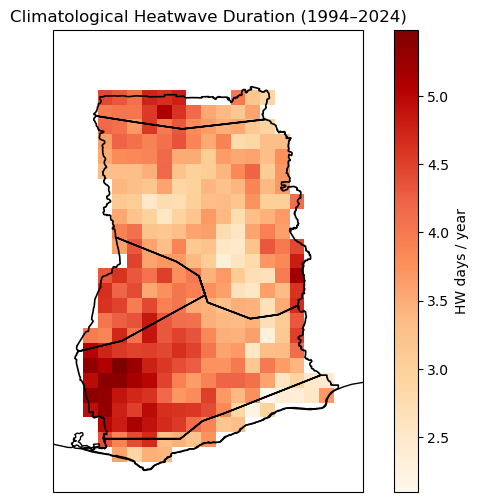

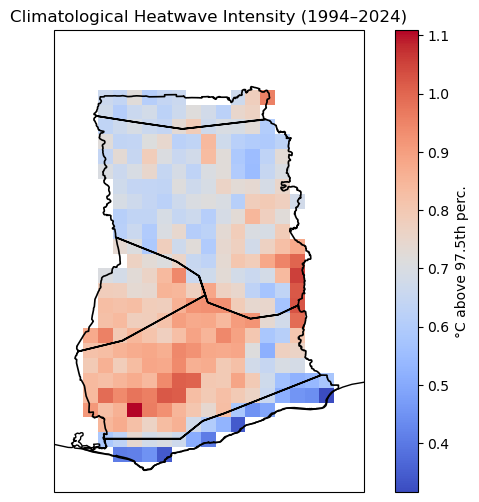

In [28]:
# --- Heatwave Duration ---
hw_duration_mean = hw_duration.mean(dim="year")
hw_duration_masked = hw_duration_mean.where(mask.mask(hw_duration_mean) == 0)

plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())

hw_duration_masked.plot(
    ax=ax, 
    cmap="OrRd", 
    cbar_kwargs={'label':'HW days / year'},
    transform=ccrs.PlateCarree()
)

ghana.boundary.plot(ax=ax, edgecolor="black", linewidth=1.2, transform=ccrs.PlateCarree())
ax.coastlines(resolution="10m")
ax.set_title("Climatological Heatwave Duration (1994–2024)")
plt.show()


# --- Heatwave Intensity ---
hw_intensity_mean = hw_intensity.mean(dim="year")
hw_intensity_masked = hw_intensity_mean.where(mask.mask(hw_intensity_mean) == 0)

plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())

hw_intensity_masked.plot(
    ax=ax, 
    cmap="coolwarm", 
    cbar_kwargs={'label':'°C above 97.5th perc.'},
    transform=ccrs.PlateCarree()
)

ghana.boundary.plot(ax=ax, edgecolor="black", linewidth=1.2, transform=ccrs.PlateCarree())
ax.coastlines(resolution="10m")
ax.set_title("Climatological Heatwave Intensity (1994–2024)")
plt.show()


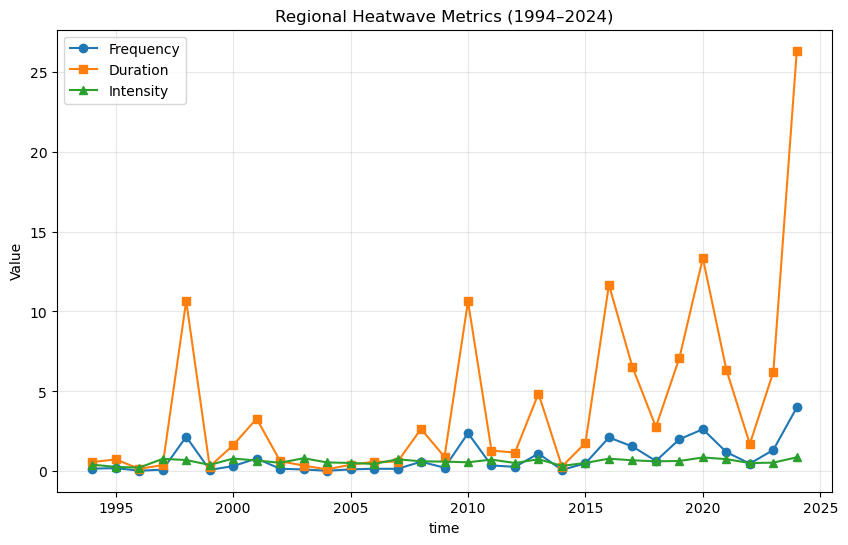

In [19]:
# Average over all gridpoints
hw_freq_regional = hw_frequency.mean(dim=("latitude","longitude"))
hw_dur_regional  = hw_duration.mean(dim=("latitude","longitude"))
hw_int_regional  = hw_intensity.mean(dim=("latitude","longitude"))

plt.figure(figsize=(10,6))
hw_freq_regional.plot(marker='o', label="Frequency")
hw_dur_regional.plot(marker='s', label="Duration")
hw_int_regional.plot(marker='^', label="Intensity")
plt.title("Regional Heatwave Metrics (1994–2024)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


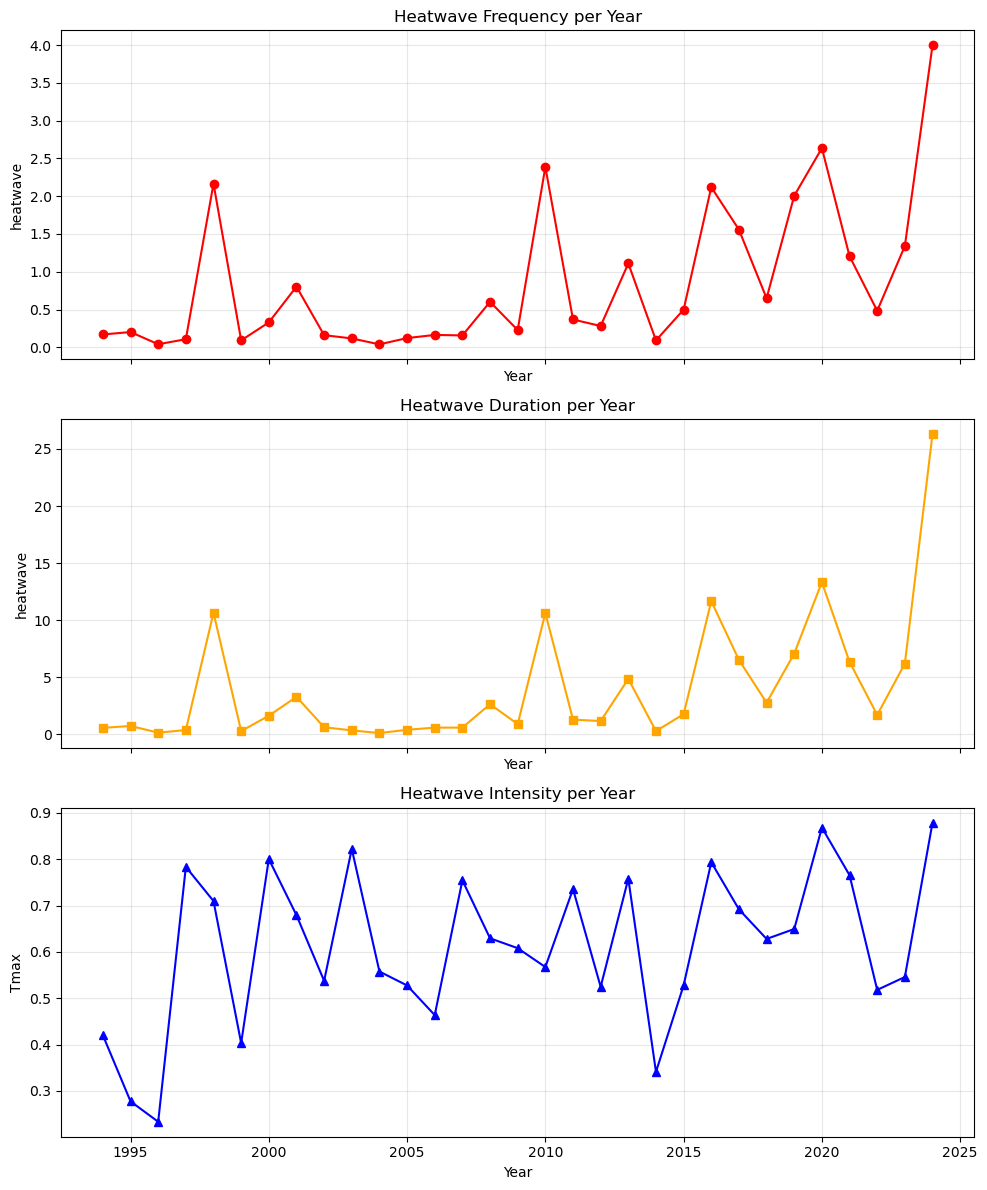

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(10,12), sharex=True)

hw_freq_regional.plot(ax=axes[0], marker='o', color='r')
axes[0].set_title("Heatwave Frequency per Year")

hw_dur_regional.plot(ax=axes[1], marker='s', color='orange')
axes[1].set_title("Heatwave Duration per Year")

hw_int_regional.plot(ax=axes[2], marker='^', color='blue')
axes[2].set_title("Heatwave Intensity per Year")

for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Year")

plt.tight_layout()
plt.show()


MONTHLY VARIATION

Step 1 — compute monthly thresholds (97.5th and 81st percentiles)-------------------------------------------------What this does: for each calendar month (Jan..Dec) it pools all days from that month across 1994–2024 and finds the 97.5th (and 81st) percentile of daily Tmax at each grid cell.

In [18]:
# Step 1: Add a 'month' coordinate and compute monthly percentile thresholds
ds_daily = ds_daily.assign_coords(month=ds_daily["valid_time"].dt.month)

# 97.5th and 81st percentiles for Tmax per calendar month (all years pooled per month)
tmax_p975_month = ds_daily["Tmax"].groupby("month").quantile(0.975, dim="valid_time")
tmax_p81_month  = ds_daily["Tmax"].groupby("month").quantile(0.81,  dim="valid_time")

# tmax_p975_month dims: ('month', 'latitude', 'longitude')
print(tmax_p975_month)


<xarray.DataArray 'Tmax' (month: 12, latitude: 31, longitude: 21)>
dask.array<concatenate, shape=(12, 31, 21), dtype=float64, chunksize=(1, 31, 21), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 12.0 11.75 11.5 11.25 ... 5.25 5.0 4.75 4.5
  * longitude  (longitude) float64 -3.5 -3.25 -3.0 -2.75 ... 0.75 1.0 1.25 1.5
    quantile   float64 0.975
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12


In [19]:
# Step 2: Exceedance arrays compared to monthly thresholds
exceed_p975 = ds_daily["Tmax"].groupby("month") > tmax_p975_month
exceed_p81  = ds_daily["Tmax"].groupby("month") > tmax_p81_month

# These are boolean DataArrays with dims (valid_time, latitude, longitude)
print(exceed_p975)


C:\Users\ampon\anaconda3\lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]


<xarray.DataArray 'Tmax' (valid_time: 11323, latitude: 31, longitude: 21)>
dask.array<gt, shape=(11323, 31, 21), dtype=bool, chunksize=(31, 31, 21), chunktype=numpy.ndarray>
Coordinates:
    number      int64 0
  * latitude    (latitude) float64 12.0 11.75 11.5 11.25 ... 5.25 5.0 4.75 4.5
  * longitude   (longitude) float64 -3.5 -3.25 -3.0 -2.75 ... 0.75 1.0 1.25 1.5
  * valid_time  (valid_time) datetime64[ns] 1994-01-01 1994-01-02 ... 2024-12-31
    year        (valid_time) int64 1994 1994 1994 1994 ... 2024 2024 2024 2024
    month       (valid_time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12
    year_month  (valid_time) int64 199401 199401 199401 ... 202412 202412 202412
    quantile    (valid_time) float64 0.975 0.975 0.975 ... 0.975 0.975 0.975


C:\Users\ampon\anaconda3\lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]


In [20]:
import numpy as np
import xarray as xr

def detect_heatwaves(exceedances, min_duration=3):
    """
    Input: exceedances = boolean DataArray (valid_time, latitude, longitude)
    Returns: DataArray boolean heatwave mask (same dims), True for days belonging to a HW run >= min_duration.
    NOTE: This function will call .compute() if the data are dask-backed (so watch memory).
    """
    # get numpy array (compute dask if present)
    try:
        exceed_arr = exceedances.data.compute()
    except Exception:
        exceed_arr = exceedances.values

    exceed = exceed_arr.astype(int)  # shape: (nt, ny, nx)
    nt, ny, nx = exceed.shape

    hw_mask = np.zeros_like(exceed, dtype=bool)

    for i in range(ny):
        for j in range(nx):
            series = exceed[:, i, j]
            run_length = 0
            for t in range(nt):
                if series[t] == 1:
                    run_length += 1
                else:
                    if run_length >= min_duration:
                        hw_mask[t-run_length:t, i, j] = True
                    run_length = 0
            # handle run at end
            if run_length >= min_duration:
                hw_mask[nt-run_length:nt, i, j] = True

    return xr.DataArray(hw_mask, coords=exceedances.coords, dims=exceedances.dims, name="heatwave")

# Detect heatwaves using the monthly 97.5% threshold
heatwave_mask = detect_heatwaves(exceed_p975, min_duration=3)  # boolean DataArray
print(heatwave_mask)


<xarray.DataArray 'heatwave' (valid_time: 11323, latitude: 31, longitude: 21)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
      

In [21]:
# Identify event starts (True on the first day of each event)
starts = heatwave_mask & ~heatwave_mask.shift(valid_time=1, fill_value=False)

# 1) Frequency: number of event starts per month-year, then climatology (mean across years)
starts_monthly = starts.resample(valid_time="1MS").sum(dim="valid_time")   # gives one value per month (YYYY-MM)
hw_freq_month_clim = starts_monthly.groupby("valid_time.month").mean(dim="valid_time")
hw_freq_month_clim.name = "mean_events_per_month"
# hw_freq_month_clim dims: ('month', 'latitude', 'longitude')

# 2) Duration: number of HW days per month-year, then climatology
hw_days_monthly = heatwave_mask.resample(valid_time="1MS").sum(dim="valid_time")
hw_duration_month_clim = hw_days_monthly.groupby("valid_time.month").mean(dim="valid_time")
hw_duration_month_clim.name = "mean_hw_days_per_month"

# 3) Intensity: (Tmax - monthly_threshold) restricted to HW days; monthly mean per month-year; then climatology
# compute exceedance above monthly 97.5% (grouped to align months)
exceedance = ds_daily["Tmax"].groupby("month") - tmax_p975_month  # this subtracts month-threshold per-month automatically
exceedance_hw = exceedance.where(heatwave_mask)   # only keep exceedances during heatwave days

# monthly mean intensity per month-year, then climatological mean across years for each month
intensity_monthly = exceedance_hw.resample(valid_time="1MS").mean(dim="valid_time")
hw_intensity_month_clim = intensity_monthly.groupby("valid_time.month").mean(dim="valid_time")
hw_intensity_month_clim.name = "mean_intensity_degC"

# quick prints
print(hw_freq_month_clim)
print(hw_duration_month_clim)
print(hw_intensity_month_clim)


C:\Users\ampon\anaconda3\lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]


<xarray.DataArray 'mean_events_per_month' (month: 12, latitude: 31,
                                           longitude: 21)>
array([[[0.09677419, 0.09677419, 0.09677419, ..., 0.12903226,
         0.12903226, 0.09677419],
        [0.09677419, 0.09677419, 0.06451613, ..., 0.12903226,
         0.12903226, 0.12903226],
        [0.12903226, 0.09677419, 0.03225806, ..., 0.12903226,
         0.12903226, 0.12903226],
        ...,
        [0.        , 0.03225806, 0.06451613, ..., 0.09677419,
         0.09677419, 0.09677419],
        [0.06451613, 0.03225806, 0.03225806, ..., 0.06451613,
         0.06451613, 0.12903226],
        [0.03225806, 0.        , 0.03225806, ..., 0.06451613,
         0.06451613, 0.06451613]],

       [[0.06451613, 0.06451613, 0.06451613, ..., 0.06451613,
         0.06451613, 0.06451613],
        [0.06451613, 0.06451613, 0.09677419, ..., 0.06451613,
         0.06451613, 0.06451613],
        [0.06451613, 0.06451613, 0.06451613, ..., 0.06451613,
         0.06451613, 0.03225

C:\Users\ampon\AppData\Local\Temp\ipykernel_13120\1653204920.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


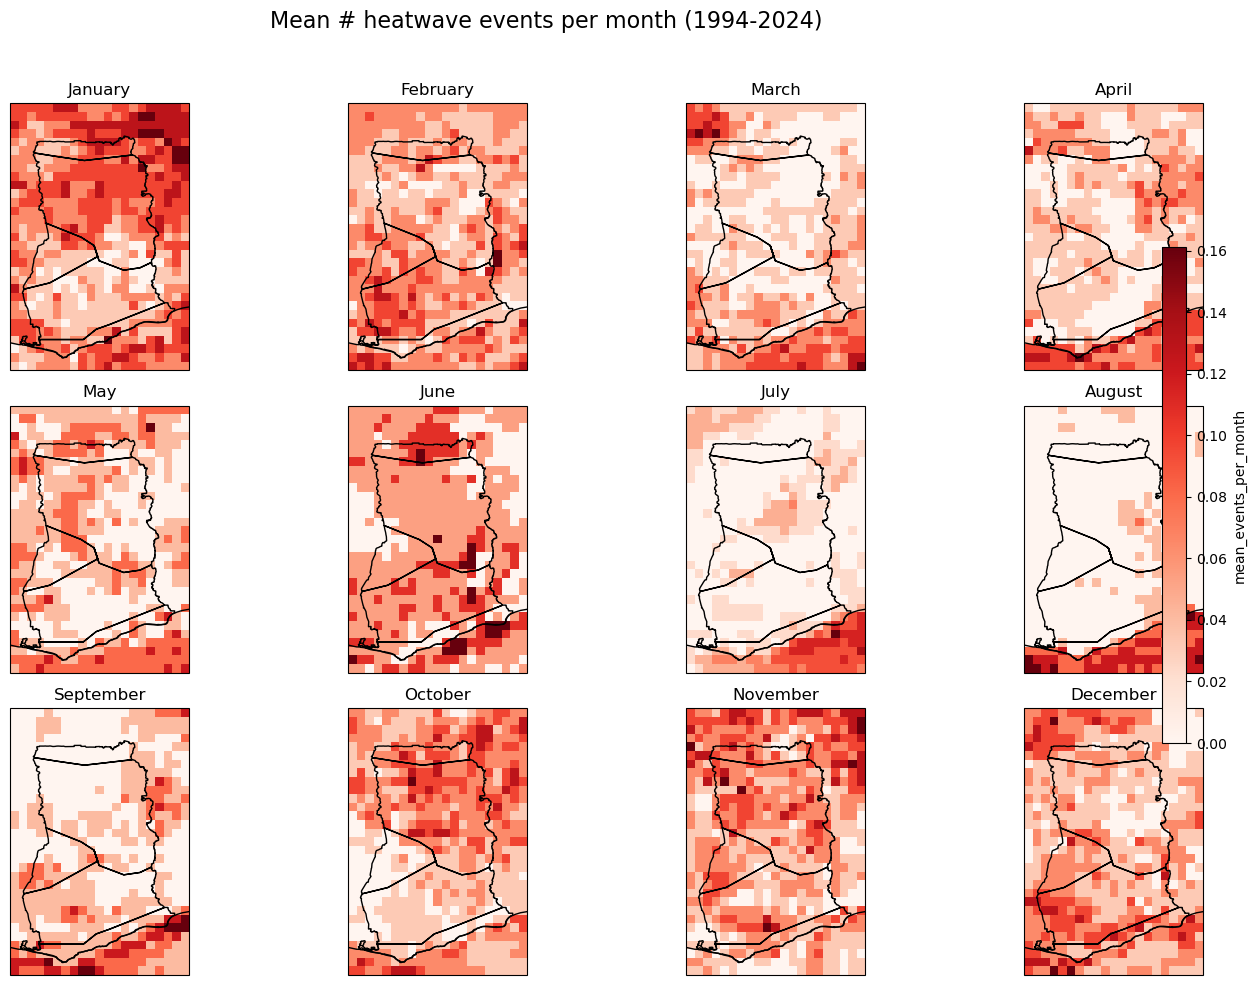

C:\Users\ampon\AppData\Local\Temp\ipykernel_13120\1653204920.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


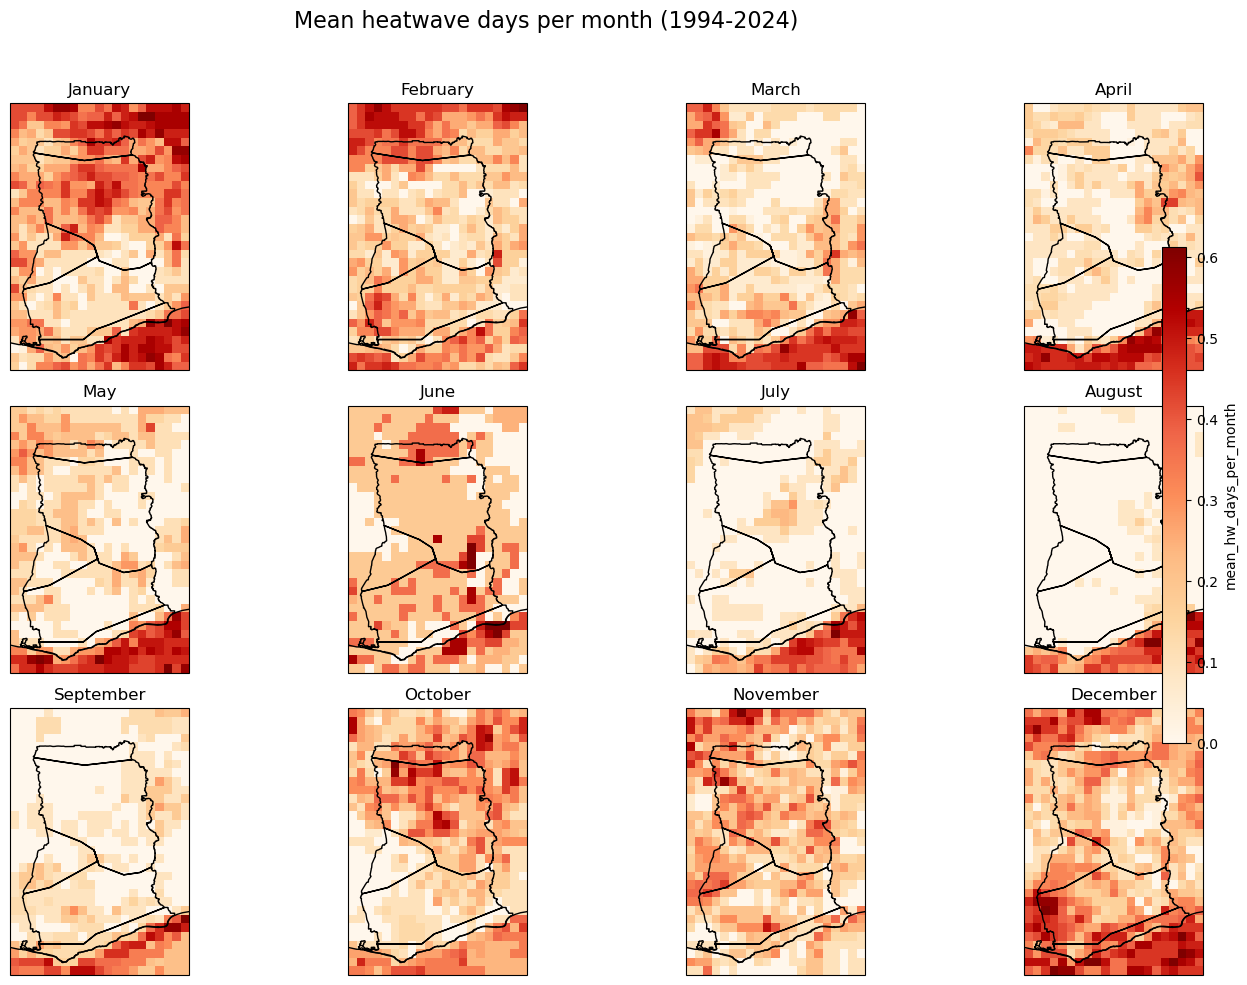

C:\Users\ampon\AppData\Local\Temp\ipykernel_13120\1653204920.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.96])


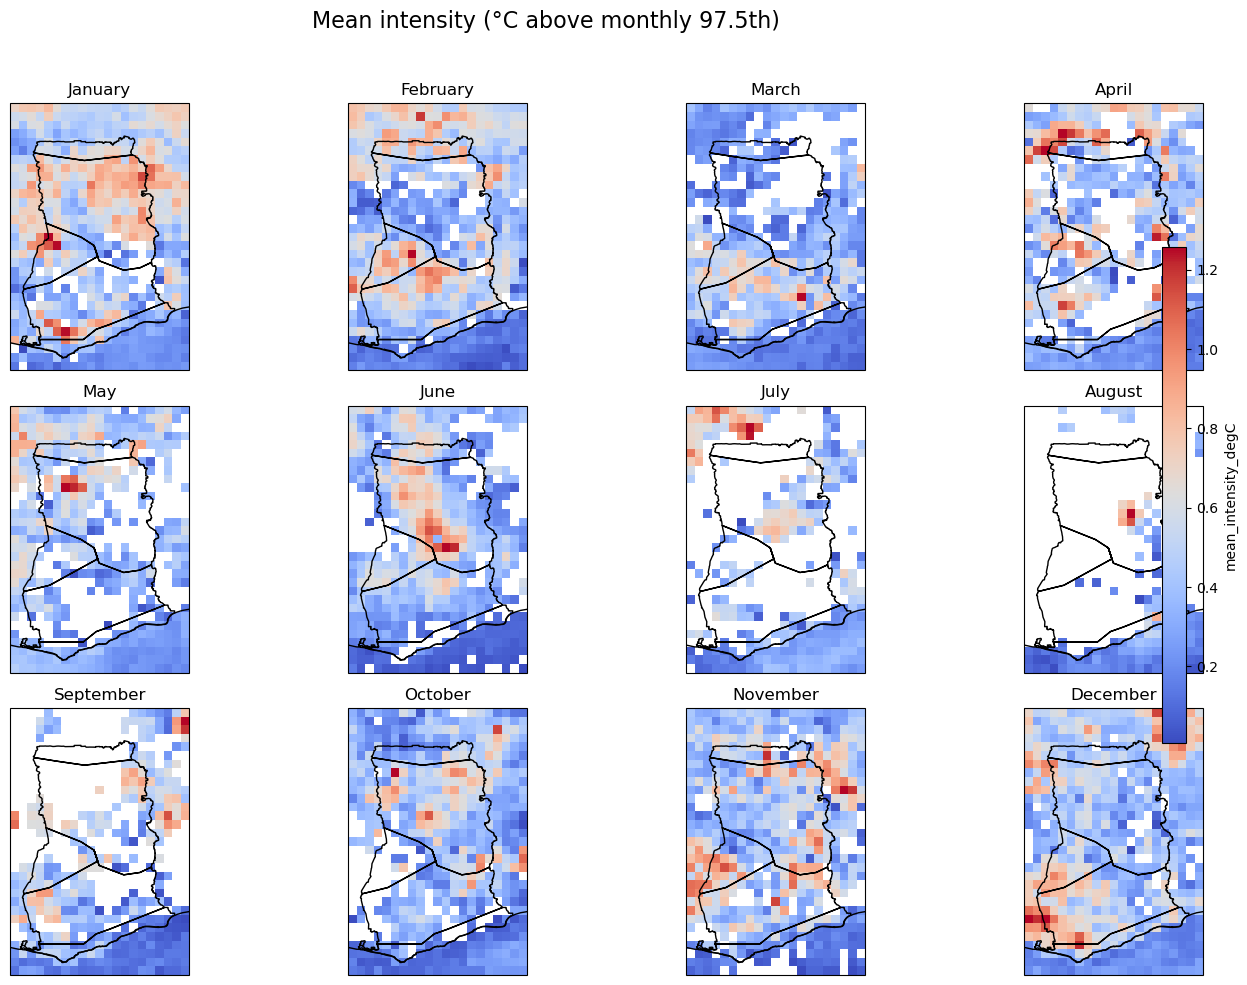

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import calendar

def plot_month_grid(da_month_clim, shapefile_gdf, cmap=None, title=""):
    """
    da_month_clim: DataArray with dim 'month' (1..12), 'latitude', 'longitude'
    shapefile_gdf: geopandas.GeoDataFrame (Ghana) for boundary overlay
    """
    fig, axes = plt.subplots(3, 4, figsize=(16, 10),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    months = range(1, 13)
    im = None
    for ax, m in zip(axes.flatten(), months):
        da = da_month_clim.sel(month=m)
        im = da.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap=cmap)
        shapefile_gdf.boundary.plot(ax=ax, edgecolor="black",
                                    linewidth=1.0, transform=ccrs.PlateCarree())
        ax.coastlines(resolution="10m")
        ax.set_title(calendar.month_name[m])
        
    # shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label(da_month_clim.name)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.92, 0.96])
    plt.show()

# Example: plot frequency climatology (mean events per month)
plot_month_grid(hw_freq_month_clim, ghana, cmap="Reds", title="Mean # heatwave events per month (1994-2024)")

# Example: plot duration climatology
plot_month_grid(hw_duration_month_clim, ghana, cmap="OrRd", title="Mean heatwave days per month (1994-2024)")

# Example: plot intensity climatology
plot_month_grid(hw_intensity_month_clim, ghana, cmap="coolwarm", title="Mean intensity (°C above monthly 97.5th)")


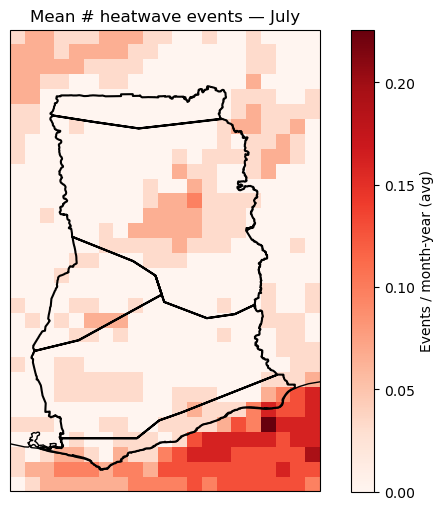

In [26]:
month = 7
fig, ax = plt.subplots(1,1, figsize=(8,6), subplot_kw={'projection': ccrs.PlateCarree()})
hw_freq_month_clim.sel(month=month).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds", cbar_kwargs={'label':'Events / month-year (avg)'})
ghana.boundary.plot(ax=ax, edgecolor='black', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title(f"Mean # heatwave events — {calendar.month_name[month]}")
plt.show()


In [33]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import calendar

def plot_month_grid(da_month_clim, shapefile_gdf, cmap=None, title=""):
    """
    da_month_clim: DataArray with dim 'month' (1..12), 'latitude', 'longitude'
    shapefile_gdf: geopandas.GeoDataFrame (Ghana) for boundary overlay
    """
    fig, axes = plt.subplots(
        3, 4, figsize=(16, 10),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    months = range(1, 13)
    im = None
    
    for ax, m in zip(axes.flatten(), months):
        da = da_month_clim.sel(month=m)
        im = da.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            add_colorbar=False, cmap=cmap
        )
        shapefile_gdf.boundary.plot(
            ax=ax, edgecolor="black",
            linewidth=1.0, transform=ccrs.PlateCarree()
        )
        ax.coastlines(resolution="10m")
        ax.set_title(calendar.month_name[m])
    
    # shared colorbar (placed outside on the right)
    cbar = fig.colorbar(
        im, ax=axes, orientation="vertical",
        fraction=0.025, pad=0.24
    )
    cbar.set_label(da_month_clim.name)

    # Adjust layout so colorbar doesn't overlap
    plt.subplots_adjust(right=0.9, wspace=0.05, hspace=0.25)
    
    fig.suptitle(title, fontsize=16)
    plt.show()


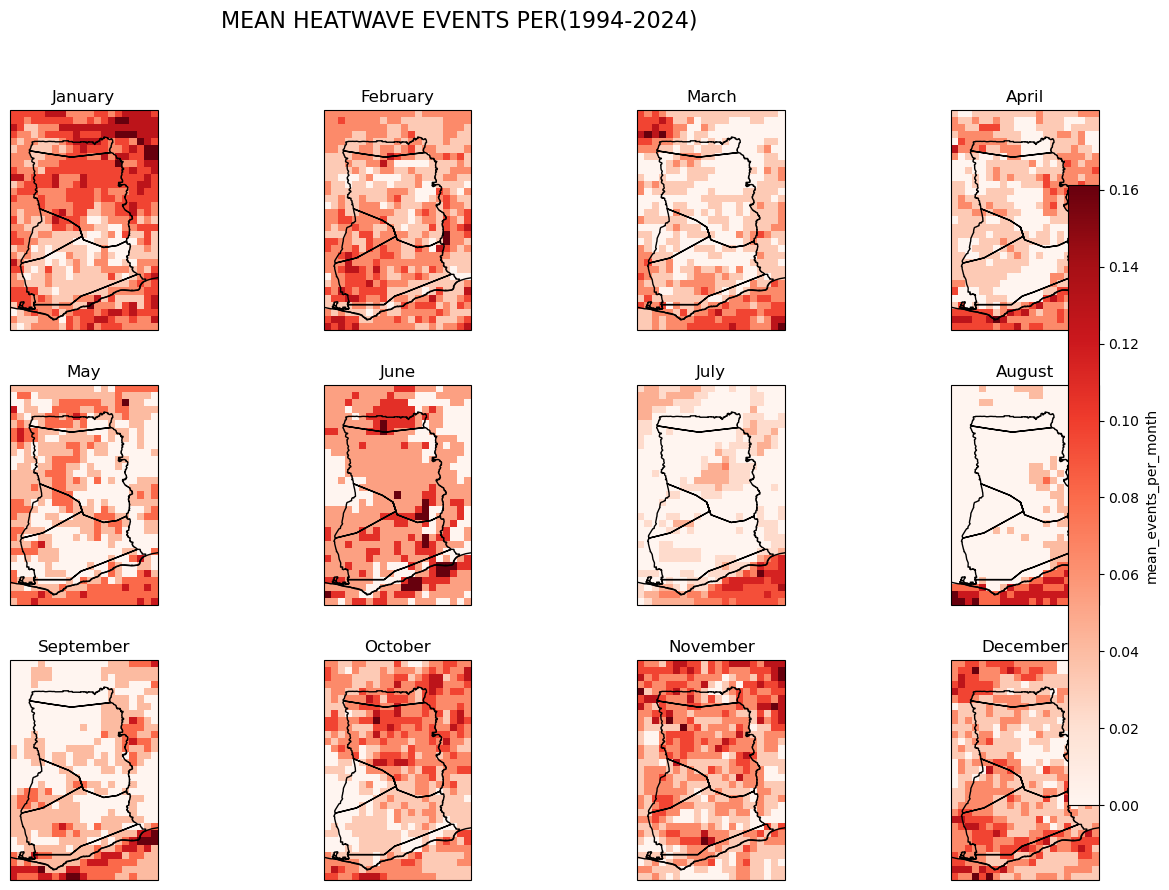

In [34]:
# Example: plot frequency climatology (mean events per month)
plot_month_grid(hw_freq_month_clim, ghana, cmap="Reds", title="MEAN HEATWAVE EVENTS PER(1994-2024)")


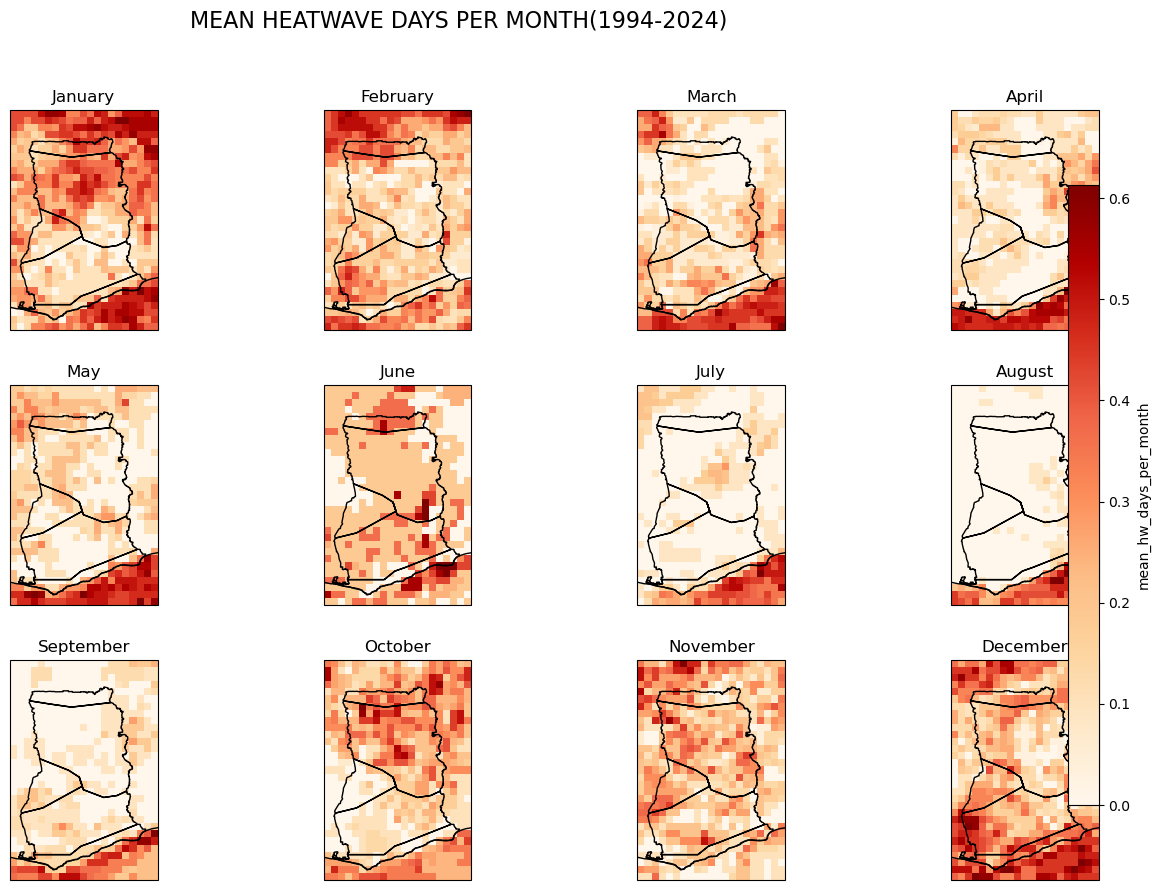

In [35]:
# Example: plot duration climatology
plot_month_grid(hw_duration_month_clim, ghana, cmap="OrRd", title="MEAN HEATWAVE DAYS PER MONTH(1994-2024)")


In [ ]:
# Example: plot intensity climatology
plot_month_grid(hw_intensity_month_clim, ghana, cmap="coolwarm", title="MEAN INTENSITY(°C ABOVE MONTHLY 97.5th)")


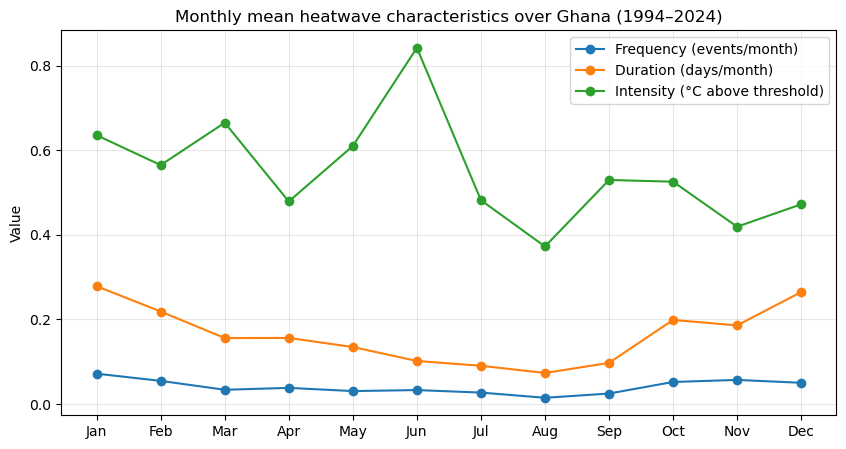

In [27]:
# Ghana-average (mask already applied to keep only inside Ghana if you want)
freq_mean_Ghana = hw_freq_month_clim.mean(dim=["latitude","longitude"])
dur_mean_Ghana  = hw_duration_month_clim.mean(dim=["latitude","longitude"])
int_mean_Ghana  = hw_intensity_month_clim.mean(dim=["latitude","longitude"])

import matplotlib.pyplot as plt
import calendar

months = range(1,13)
month_names = [calendar.month_abbr[m] for m in months]

plt.figure(figsize=(10,5))
plt.plot(months, freq_mean_Ghana, "-o", label="Frequency (events/month)")
plt.plot(months, dur_mean_Ghana, "-o", label="Duration (days/month)")
plt.plot(months, int_mean_Ghana, "-o", label="Intensity (°C above threshold)")
plt.xticks(months, month_names)
plt.legend()
plt.title("Monthly mean heatwave characteristics over Ghana (1994–2024)")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
import regionmask
import geopandas as gpd

ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")
# regionmask needs polygons in a list
regs = regionmask.Regions([ghana.geometry.unary_union], names=["GHA"])

# Create mask indices for the grid (0 inside Ghana, NaN outside)
mask = regs.mask(freq_month_clim, lon_name="longitude", lat_name="latitude")
# mask values: 0 for inside region (index), NaN for outside
inside_mask = mask == 0  # boolean


In [ ]:
freq_masked = freq_month_clim.where(inside_mask)
days_masked = days_month_clim.where(inside_mask)
intensity_masked = intensity_month_clim.where(inside_mask)


NameError: name 'freq_masked' is not defined

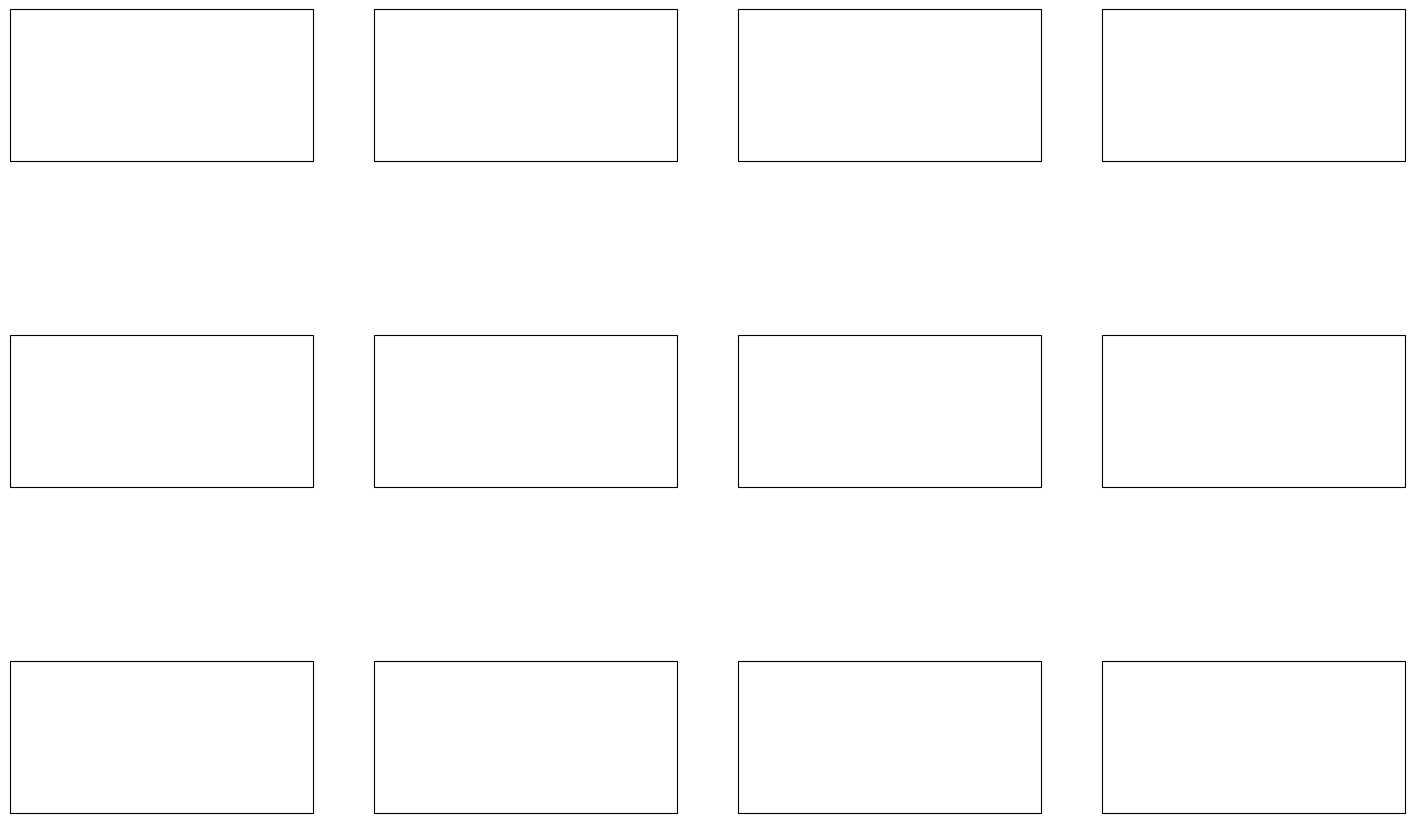

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

fig, axes = plt.subplots(3, 4, figsize=(18,12), subplot_kw={"projection": ccrs.PlateCarree()})
for m, ax in enumerate(axes.flat, start=1):
    da = freq_masked.sel(month=m)
    im = da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="Reds",
        add_colorbar=False,
        vmin=0,  # optionally set sensible vmin/vmax
    )
    # overlay Ghana boundary
    ghana.boundary.plot(ax=ax, edgecolor="black", linewidth=1, transform=ccrs.PlateCarree())
    ax.set_title(months[m-1])
    ax.set_extent([-4, 2, 4, 13])  # slightly larger box around Ghana
    ax.coastlines(resolution="10m", linewidth=0.6)

# shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.05, pad=0.05)
cbar.set_label("Average number of event starts per month (1994–2024)")
plt.suptitle("Monthly Climatology — Heatwave Frequency (1994–2024)", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# National monthly averages for quick check
monthly_national_freq = freq_month_clim.mean(dim=["latitude","longitude"])
monthly_national_freq.plot(marker='o', xticks=range(1,13), figsize=(8,4))
plt.xticks(range(1,13), months, rotation=45)
plt.ylabel("Events / month (avg 1994–2024)")
plt.title("National monthly heatwave frequency (climatology)")
plt.grid(alpha=0.3)
plt.show()


In [15]:
tmax_p90

<xarray.DataArray 'Tmax' (dayofyear: 366, latitude: 31, longitude: 21)>
dask.array<concatenate, shape=(366, 31, 21), dtype=float64, chunksize=(1, 31, 21), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 12.0 11.75 11.5 11.25 ... 5.25 5.0 4.75 4.5
  * longitude  (longitude) float64 -3.5 -3.25 -3.0 -2.75 ... 0.75 1.0 1.25 1.5
    quantile   float64 0.9
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

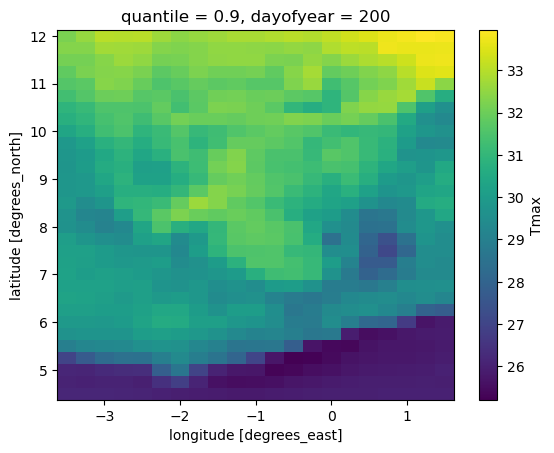

In [16]:
tmax_p90.sel(dayofyear=200).plot()


NEW FORMAT

In [21]:
# Ensure time is in a single chunk
ds_daily = ds_daily.chunk(dict(valid_time=-1))


In [22]:
# Group Tmax by day of year
tmax_doy = ds_daily["Tmax"].groupby("valid_time.dayofyear")

# 97.5th (T1) and 81st (T2) percentiles
tmax_p975 = tmax_doy.quantile(0.975, dim="valid_time")
tmax_p81  = tmax_doy.quantile(0.81,  dim="valid_time")

# Rechunk thresholds for later apply_ufunc use
tmax_p975 = tmax_p975.chunk(dict(dayofyear=-1, latitude=31, longitude=21))
tmax_p81  = tmax_p81.chunk(dict(dayofyear=-1, latitude=31, longitude=21))


In [17]:
# Align Tmax with the climatological percentile
tmax_threshold = tmax_p90.sel(dayofyear=ds_daily["valid_time"].dt.dayofyear)

# Boolean mask: where Tmax exceeds its threshold
exceedance = ds_daily["Tmax"] > tmax_threshold


C:\Users\ampon\anaconda3\lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]


In [18]:
import numpy as np

def detect_heatwaves(mask, tmax, threshold, min_duration=3):
    """
    Identify heatwaves and compute duration + magnitude.
    mask: boolean exceedance array (time,)
    tmax: daily Tmax array (time,)
    threshold: threshold array (time,)
    """
    mask = mask.astype(int)
    diff = np.diff(mask, prepend=0, append=0)
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]

    event_id = np.zeros_like(mask, dtype=int)
    durations, magnitudes = [], []

    eid = 1
    for s, e in zip(starts, ends):
        if (e - s) >= min_duration:
            event_id[s:e] = eid
            durations.append(e - s)
            # Magnitude = mean anomaly above threshold
            magnitudes.append(float(np.mean(tmax[s:e] - threshold[s:e])))
            eid += 1

    return event_id, np.array(durations), np.array(magnitudes)


In [19]:
import xarray as xr

heatwave_events, durations, magnitudes = xr.apply_ufunc(
    detect_heatwaves,
    exceedance,
    ds_daily["Tmax"],
    tmax_threshold,
    input_core_dims=[["valid_time"], ["valid_time"], ["valid_time"]],
    output_core_dims=[["valid_time"], ["event"], ["event"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int, float, float],
    output_sizes={"event": 2000}  # generous max events
)


C:\Users\ampon\AppData\Local\Temp\ipykernel_24612\3798549858.py:3: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  heatwave_events, durations, magnitudes = xr.apply_ufunc(


ValueError: dimension valid_time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(valid_time=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [20]:
# Make sure time is in one chunk
ds_daily = ds_daily.chunk(dict(valid_time=-1))
tmax_threshold = tmax_threshold.chunk(dict(dayofyear=-1))
exceedance = exceedance.chunk(dict(valid_time=-1))

heatwave_events, durations, magnitudes = xr.apply_ufunc(
    detect_heatwaves,
    exceedance,
    ds_daily["Tmax"],
    tmax_threshold,
    input_core_dims=[["valid_time"], ["valid_time"], ["valid_time"]],
    output_core_dims=[["valid_time"], ["event"], ["event"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int, float, float],
    dask_gufunc_kwargs={"output_sizes": {"event": 2000}}  # moved here
)


ValueError: some chunks keys are not dimensions on this object: {'dayofyear'}

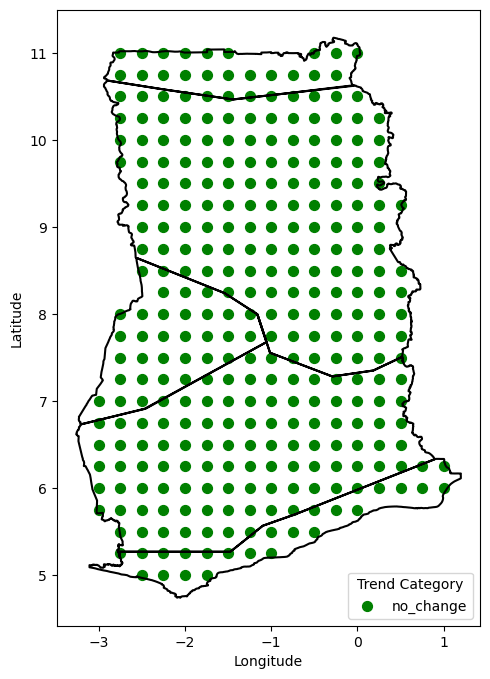

In [18]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Load Ghana shapefile
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")

# 2. Open dataset
ds = xr.open_mfdataset("C:/Users/ampon/Desktop/PYTHON/TEMP_1994_2024/*.nc")

# 3. Convert hourly → annual mean
t2m = ds["t2m"] - 273.15   # Kelvin → °C
t2m_ann = t2m.resample(valid_time="1YE").mean()

# 4. Compute linear trend (slope °C/year)
coeffs = t2m_ann.polyfit(dim="valid_time", deg=1)
trend = coeffs["polyfit_coefficients"].sel(degree=1)

# 5. Classify into categories
trend_class = xr.full_like(trend, "no_change", dtype="U10")
trend_class = xr.where(trend >= 0.02, "warming", trend_class)
trend_class = xr.where(trend <= -0.02, "cooling", trend_class)

# 6. Convert to GeoDataFrame
df = trend_class.to_dataframe(name="trend_class").reset_index()
gdf_points = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

# 7. Clip to Ghana boundary (only keep points inside Ghana)
gdf_points = gpd.sjoin(gdf_points, ghana, predicate="within")

# 8. Plot categorical trends INSIDE Ghana only
fig, ax = plt.subplots(figsize=(8,8))
ghana.boundary.plot(ax=ax, color="black")

colors = {"warming":"red", "cooling":"blue", "no_change":"green"}
markers = {"warming":"^", "cooling":"v", "no_change":"o"}

for cat, subset in gdf_points.groupby("trend_class"):
    subset.plot(ax=ax, markersize=50, marker=markers[cat],
                color=colors[cat], label=cat)

plt.legend(title="Trend Category")
#plt.title("Categorical Temperature Trends over Ghana (1994–2024)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig('temp.png')
plt.show()


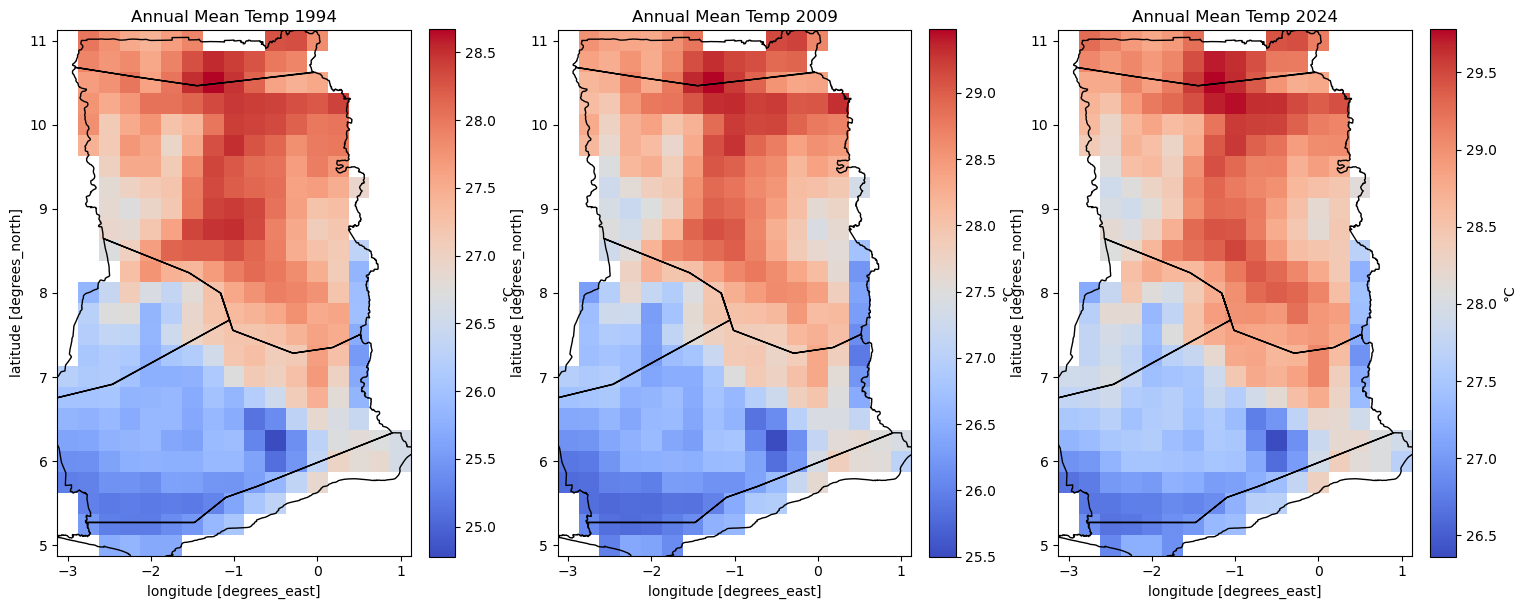

In [22]:
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray

# 1. Load Ghana shapefile
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")

# 2. Open dataset
ds = xr.open_mfdataset("C:/Users/ampon/Desktop/PYTHON/TEMP_1994_2024/*.nc")

# 3. Convert Kelvin → Celsius
t2m = ds["t2m"] - 273.15
t2m = t2m.rio.write_crs("EPSG:4326")

# 4. Clip to Ghana
t2m_ghana = t2m.rio.clip(ghana.geometry, ghana.crs, drop=True)

# 5. Annual mean
t2m_ann = t2m_ghana.resample(valid_time="1YE").mean()

# 6. Pick years to plot (first, middle, last for illustration)
years_to_plot = [1994, 2009, 2024]

# 7. Plot annual maps
fig, axes = plt.subplots(1, len(years_to_plot), figsize=(15, 6), constrained_layout=True)

for ax, year in zip(axes, years_to_plot):
    da = t2m_ann.sel(valid_time=str(year))
    da.plot(ax=ax, cmap="coolwarm", cbar_kwargs={"label": "°C"})
    ghana.boundary.plot(ax=ax, color="black", linewidth=1)
    ax.set_title(f"Annual Mean Temp {year}")

# plt.savefig("ghana_annual_maps.png", dpi=300)
plt.show()


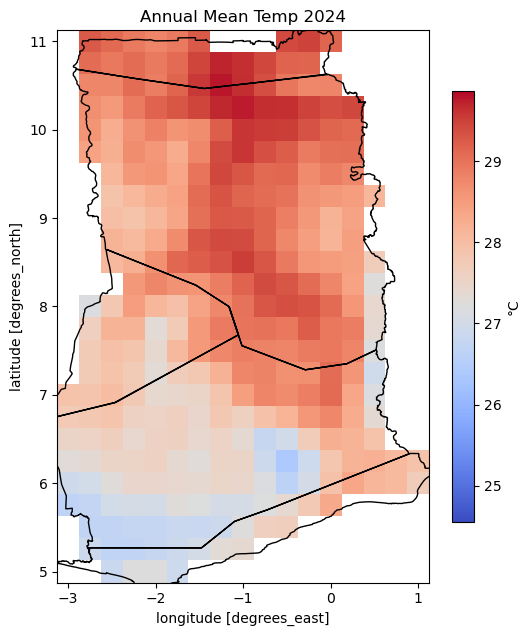

In [23]:
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
from matplotlib.animation import FuncAnimation

# 1. Load Ghana shapefile
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")

# 2. Open dataset
ds = xr.open_mfdataset("C:/Users/ampon/Desktop/PYTHON/TEMP_1994_2024/*.nc")

# 3. Convert Kelvin → Celsius
t2m = ds["t2m"] - 273.15
t2m = t2m.rio.write_crs("EPSG:4326")

# 4. Clip to Ghana
t2m_ghana = t2m.rio.clip(ghana.geometry, ghana.crs, drop=True)

# 5. Annual mean
t2m_ann = t2m_ghana.resample(valid_time="1YE").mean()

# 6. Set up animation
fig, ax = plt.subplots(figsize=(6, 8))
ghana.boundary.plot(ax=ax, color="black", linewidth=1)

cmap = "coolwarm"
vmin = float(t2m_ann.min())
vmax = float(t2m_ann.max())

im = None
title = ax.set_title("")

def update(frame):
    global im
    year = pd.to_datetime(str(t2m_ann.valid_time.values[frame])).year
    da = t2m_ann.isel(valid_time=frame)

    if im:
        im.remove()

    im = da.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
    title.set_text(f"Annual Mean Temp {year}")
    return [im]

# Add colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin, vmax)), ax=ax, shrink=0.7)
cbar.set_label("°C")

ani = FuncAnimation(fig, update, frames=len(t2m_ann.valid_time), interval=500, blit=False)

# Save animation
ani.save("ghana_temp_animation.gif", writer="pillow", dpi=150)
plt.show()


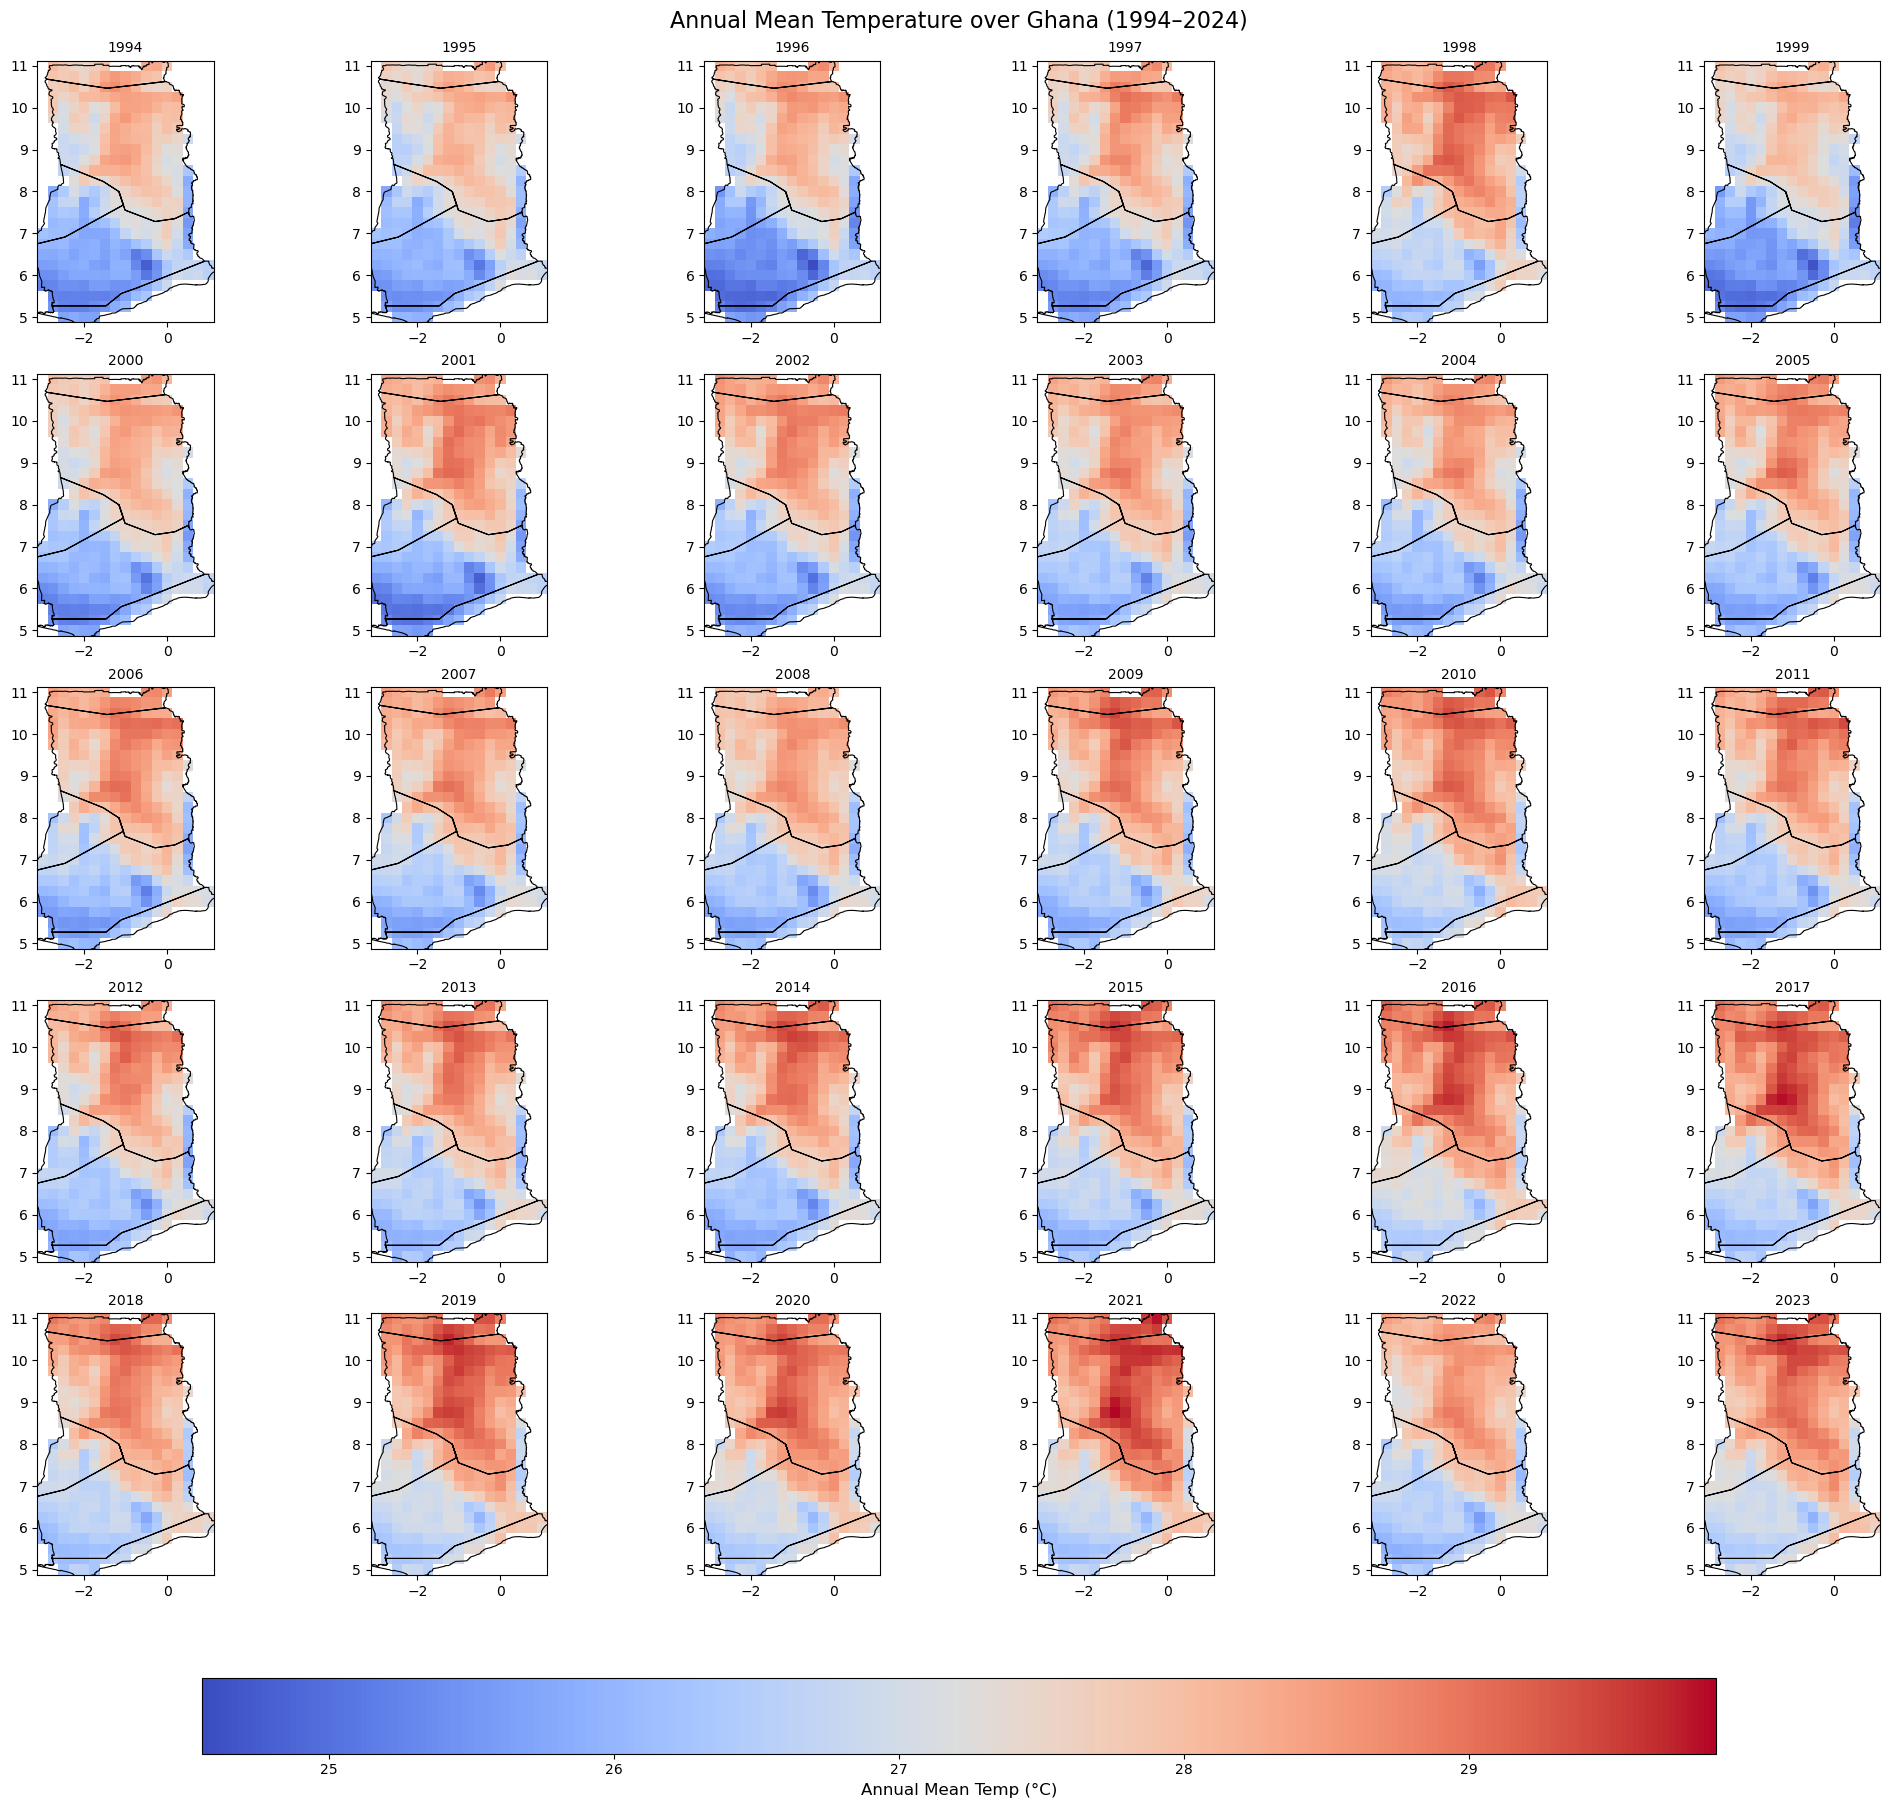

In [24]:
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import pandas as pd

# 1. Load Ghana shapefile
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp").to_crs("EPSG:4326")

# 2. Open dataset
ds = xr.open_mfdataset("C:/Users/ampon/Desktop/PYTHON/TEMP_1994_2024/*.nc")

# 3. Convert Kelvin → Celsius
t2m = ds["t2m"] - 273.15
t2m = t2m.rio.write_crs("EPSG:4326")

# 4. Clip to Ghana
t2m_ghana = t2m.rio.clip(ghana.geometry, ghana.crs, drop=True)

# 5. Annual mean
t2m_ann = t2m_ghana.resample(valid_time="1YE").mean()

# 6. Plot 30-year grid (5 x 6 subplots)
fig, axes = plt.subplots(5, 6, figsize=(20, 18), constrained_layout=True)

# Common color scale across all years
vmin = float(t2m_ann.min())
vmax = float(t2m_ann.max())

for i, ax in enumerate(axes.flat):
    if i >= len(t2m_ann.valid_time):
        ax.axis("off")
        continue

    year = pd.to_datetime(str(t2m_ann.valid_time.values[i])).year
    da = t2m_ann.isel(valid_time=i)

    da.plot(ax=ax, cmap="coolwarm", vmin=vmin, vmax=vmax,
            add_colorbar=False)

    ghana.boundary.plot(ax=ax, color="black", linewidth=0.8)
    ax.set_title(f"{year}", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Shared colorbar
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin, vmax)),
    ax=axes, orientation="horizontal", fraction=0.05, pad=0.05
)
cbar.set_label("Annual Mean Temp (°C)", fontsize=12)

plt.suptitle("Annual Mean Temperature over Ghana (1994–2024)", fontsize=16)
# plt.savefig("ghana_temp_30years.png", dpi=300)
plt.show()


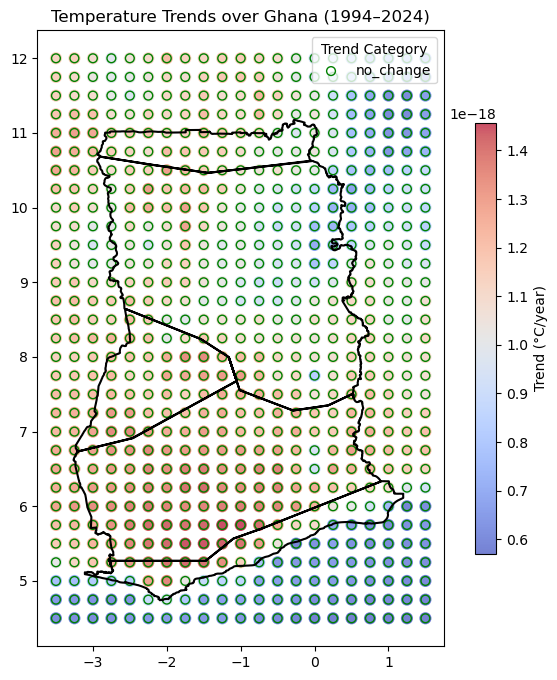

In [16]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Load Ghana shapefile
ghana = gpd.read_file("gha_admbnda_adm0_gss_20210308.shp")

# 2. Open dataset
ds = xr.open_mfdataset("C:/Users/ampon/Desktop/PYTHON/TEMP_1994_2024/*.nc")

# 3. Convert hourly → annual mean
t2m = ds["t2m"] - 273.15   # Kelvin → °C
t2m_ann = t2m.resample(valid_time="1YE").mean()  # "YE" fixes warning

# 4. Compute linear trend at each grid cell
trend = t2m_ann.polyfit(dim="valid_time", deg=1)["polyfit_coefficients"].sel(degree=1)
# slope = °C per year (trend)

# 5. Classify into categories
trend_class = xr.full_like(trend, "no_change", dtype="U10")
trend_class = xr.where(trend >= 0.02, "warming", trend_class)   # warming
trend_class = xr.where(trend <= -0.02, "cooling", trend_class)  # cooling

# 6. Convert to dataframe for plotting
df = trend.to_dataframe(name="trend").reset_index()
df["trend_class"] = trend_class.values.ravel()
gdf_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# 7. Plot
fig, ax = plt.subplots(figsize=(8,8))
ghana.boundary.plot(ax=ax, color="black")

# Continuous shading for slope values
sc = plt.scatter(df["longitude"], df["latitude"], c=df["trend"], cmap="coolwarm", s=60, alpha=0.7)

# Overlay categorical markers
colors = {"warming":"red", "cooling":"blue", "no_change":"green"}
for cat, subset in gdf_points.groupby("trend_class"):
    subset.plot(ax=ax, markersize=40, marker="o", edgecolor=colors[cat],
                facecolor="none", label=cat)

plt.legend(title="Trend Category")
cbar = plt.colorbar(sc, ax=ax, shrink=0.7, label="Trend (°C/year)")
plt.title("Temperature Trends over Ghana (1994–2024)")
plt.savefig('tt.png')
plt.show()
